In [174]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from statsmodels.tsa.statespace.sarimax import SARIMAX
import mplfinance as mpf

In [176]:
# %pip uninstall tensorflow tensorflow-intel protobuf googleapis-common-protos -y
# %pip uninstall prophet fbprophet -y
%pip install prophet==1.1.5 cmdstanpy==1.2.0

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


##  DATA COLLECTION USING THE BINANCE API


In [177]:
from binance.client import Client

# Public (no API key required for historical data)
client = Client()

# Get historical klines (candlestick data)
symbol = "BTCUSDT"
interval = Client.KLINE_INTERVAL_1DAY
data_time = "7 years ago UTC"
# data_timeperiod = "1 Jan 2020"

klines = client.get_historical_klines(symbol, interval, data_time)

# Convert to DataFrame
columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time',
           'quote_asset_volume', 'number_of_trades', 
           'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']

df = pd.DataFrame(klines, columns=columns)

df.head()

,timestamp,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
0,1548806400000,3410.04000000,3478.00000000,3387.10000000,3458.18000000,23968.26024300,1548892799999,82521122.86191754,180820,13324.33962800,45877250.05787340,0
1,1548892800000,3457.50000000,3489.20000000,3418.80000000,3434.10000000,29607.19025300,1548979199999,101928346.97699686,198100,15325.82878300,52764623.95051864,0
2,1548979200000,3434.10000000,3488.00000000,3401.20000000,3462.07000000,25260.47615900,1549065599999,87075914.23266830,167520,13533.34462800,46664199.94907889,0
3,1549065600000,3462.20000000,3526.40000000,3440.29000000,3504.77000000,17920.80200000,1549151999999,62134037.97539881,153234,9637.41923000,33417963.69624554,0
4,1549152000000,3504.06000000,3511.09000000,3426.00000000,3458.11000000,19867.33639000,1549238399999,68801620.06241606,138592,10126.71614300,35070884.46205618,0


                    DATA PREPROCESSSING

In [178]:
df["timestamp"] =  pd.to_datetime(df["timestamp"],unit='ms')
df[["open","high","low","close","volume"]] = df[["open","high","low","close","volume"]].astype(float)
total_Data = len(df)
total_Data

2557

In [179]:
modified_data = df.replace(0,np.nan)
modified_data.head()

,timestamp,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
0,2019-01-30,3410.04,3478.00,3387.10,3458.18,23968.260243,1548892799999,82521122.86191754,180820,13324.33962800,45877250.05787340,0
1,2019-01-31,3457.50,3489.20,3418.80,3434.10,29607.190253,1548979199999,101928346.97699686,198100,15325.82878300,52764623.95051864,0
2,2019-02-01,3434.10,3488.00,3401.20,3462.07,25260.476159,1549065599999,87075914.23266830,167520,13533.34462800,46664199.94907889,0
3,2019-02-02,3462.20,3526.40,3440.29,3504.77,17920.802000,1549151999999,62134037.97539881,153234,9637.41923000,33417963.69624554,0
4,2019-02-03,3504.06,3511.09,3426.00,3458.11,19867.336390,1549238399999,68801620.06241606,138592,10126.71614300,35070884.46205618,0


In [180]:
df.head()

,timestamp,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
0,2019-01-30,3410.04,3478.00,3387.10,3458.18,23968.260243,1548892799999,82521122.86191754,180820,13324.33962800,45877250.05787340,0
1,2019-01-31,3457.50,3489.20,3418.80,3434.10,29607.190253,1548979199999,101928346.97699686,198100,15325.82878300,52764623.95051864,0
2,2019-02-01,3434.10,3488.00,3401.20,3462.07,25260.476159,1549065599999,87075914.23266830,167520,13533.34462800,46664199.94907889,0
3,2019-02-02,3462.20,3526.40,3440.29,3504.77,17920.802000,1549151999999,62134037.97539881,153234,9637.41923000,33417963.69624554,0
4,2019-02-03,3504.06,3511.09,3426.00,3458.11,19867.336390,1549238399999,68801620.06241606,138592,10126.71614300,35070884.46205618,0


In [181]:
df.columns

Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time',
       'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume',
       'taker_buy_quote_asset_volume', 'ignore'],
      dtype='object')

In [182]:
# df.drop(columns=['ignore'], inplace=True)
# df.head()
# df = df[df[['open','high','low','close','volume']].ne(0).all(axis=1)]
# len(df)

df.describe()
# df.head()
# df.info()
df.columns
df.isnull().sum()
df.shape
# df.value_counts().values
# data=df.set_index('timestamp') # set index
# df_reset = df_indexed.reset_index()  # reset the index

(2557, 12)

In [183]:
# REMOVING IGNORE COLUMN BECAUSE ITS FULL OF ZERO, SO IT WOULD AFFECT 
# data= df.drop(columns=['ignore'], inplace=True
data = df

In [184]:
data.head()

,timestamp,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
0,2019-01-30,3410.04,3478.00,3387.10,3458.18,23968.260243,1548892799999,82521122.86191754,180820,13324.33962800,45877250.05787340,0
1,2019-01-31,3457.50,3489.20,3418.80,3434.10,29607.190253,1548979199999,101928346.97699686,198100,15325.82878300,52764623.95051864,0
2,2019-02-01,3434.10,3488.00,3401.20,3462.07,25260.476159,1549065599999,87075914.23266830,167520,13533.34462800,46664199.94907889,0
3,2019-02-02,3462.20,3526.40,3440.29,3504.77,17920.802000,1549151999999,62134037.97539881,153234,9637.41923000,33417963.69624554,0
4,2019-02-03,3504.06,3511.09,3426.00,3458.11,19867.336390,1549238399999,68801620.06241606,138592,10126.71614300,35070884.46205618,0


In [185]:
data.describe()

,timestamp,open,high,low,close,volume,close_time,number_of_trades
count,2557,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000,2.557000e+03,2.557000e+03
mean,2022-07-31 00:00:00,42459.687079,43337.674290,41526.000704,42492.918514,69151.123892,1.659312e+12,2.240810e+06
min,2019-01-30 00:00:00,3398.400000,3426.450000,3373.100000,3398.400000,3104.117220,1.548893e+12,1.240460e+05
25%,2020-10-30 00:00:00,13549.630000,13859.480000,13115.000000,13560.100000,26271.657398,1.604102e+12,7.580610e+05
50%,2022-07-31 00:00:00,33949.530000,34933.000000,32658.340000,34038.400000,43556.061025,1.659312e+12,1.428738e+06
75%,2024-04-30 00:00:00,62086.000000,63417.560000,60630.000000,62135.470000,73931.896350,1.714522e+12,2.845696e+06
max,2026-01-29 00:00:00,124658.540000,126199.630000,123084.000000,124658.540000,760705.362783,1.769731e+12,1.522359e+07
std,NaN,32434.390669,32939.603229,31889.718035,32437.837144,81929.380660,6.378797e+10,2.244601e+06


In [186]:
# data = data.to_csv(r"C:\ALL PROJECTS\Time-Series-Crypto-Analysis\binance_crypto_data.csv") /// changed data to verify the progress 

In [187]:
data.head()
data=data.reset_index()

EDA PROCESS

Closing price trend line - done Candle stick chart - to compare open, high, low, close --->done Volume trend chart - x axis -date , y axis - volume --->done Correlation heatmap we already did ------> done

Seasonal decomposition

Seasonal decomposition = seasonal_decompose(df['close'], model='additive', period=30) decomposition.plot() plt.show()

voltality(daily returns and moving avgs)

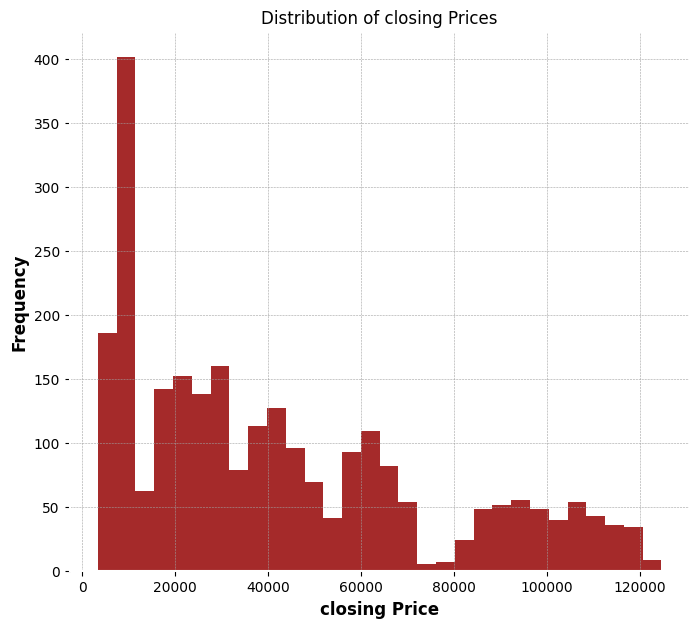

In [188]:
# distribution of closing price
plt.figure(figsize=(8,7))
plt.hist(data['close'], bins=30,color="brown")
plt.title("Distribution of closing Prices")
plt.xlabel("closing Price")
plt.ylabel("Frequency")
plt.show()

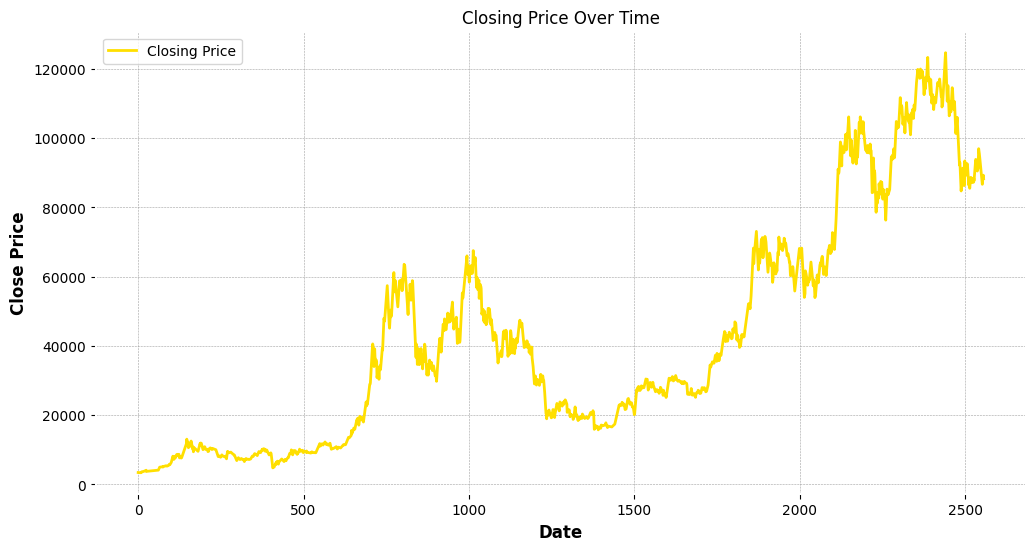

In [189]:
# Closing Price Trend
plt.figure(figsize=(12,6))
plt.plot(data['close'], label='Closing Price', color='#FFDF00')
plt.title("Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
# plt.grid("False")
plt.show()

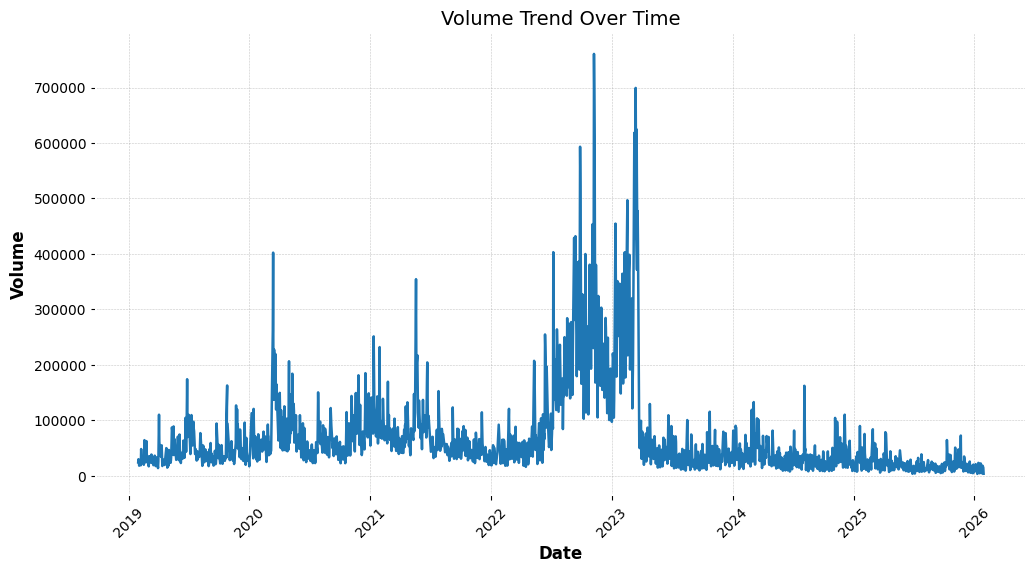

In [190]:
# Volume trend chart

plt.figure(figsize=(12,6))
plt.plot(data['timestamp'], data['volume'], linewidth=1.8)

# Add title and labels
plt.title("Volume Trend Over Time", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Volume", fontsize=12)

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Show grid for clarity
plt.grid(True, linestyle='--', alpha=0.6)

# Display the plot
plt.show()

   Cryptocurrency Candlestick Chart

In [191]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)


In [192]:
candlestick_df = df[['open', 'high', 'low', 'close', 'volume']]


C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


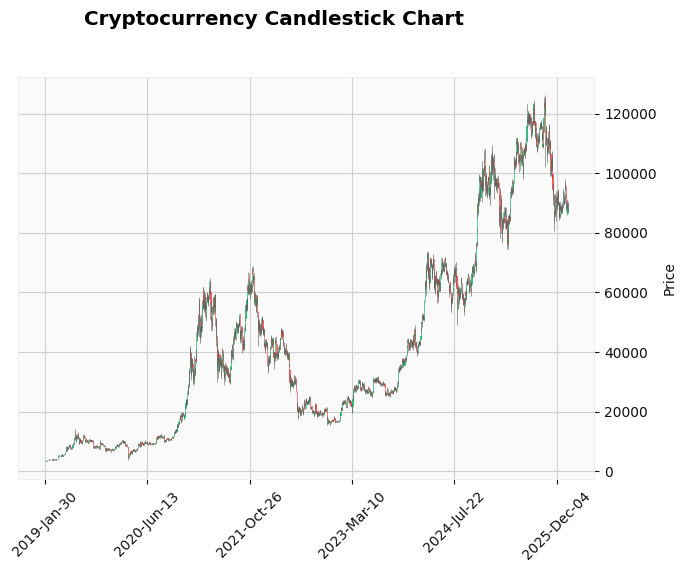

In [193]:
mpf.plot(
    candlestick_df,
    type='candle',
    style='yahoo',
    title='Cryptocurrency Candlestick Chart',
    ylabel='Price',
    volume=False
)


C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


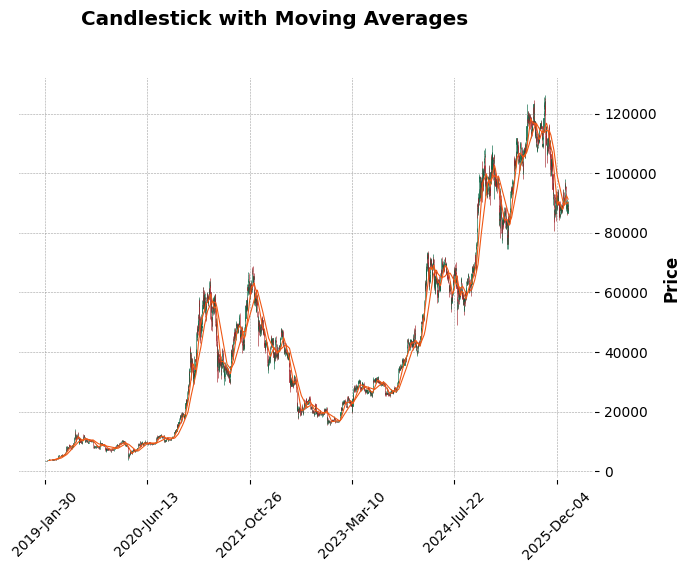

In [194]:
# CANDLESTICK - II FOR MOVING AVGS.

mpf.plot(candlestick_df,
         type='candle',
         style='charles',
         mav=(20,50),         # 20-day and 50-day moving averages
         volume=False,
         title='Candlestick with Moving Averages')

                CORRELATION HEATMAP

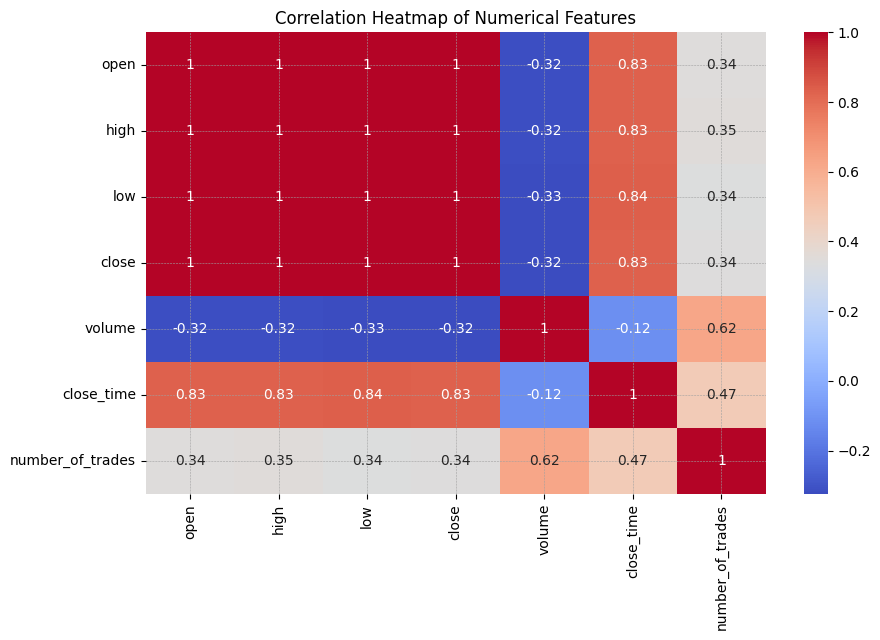

In [195]:
# CORRELATION HEATMAP

plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

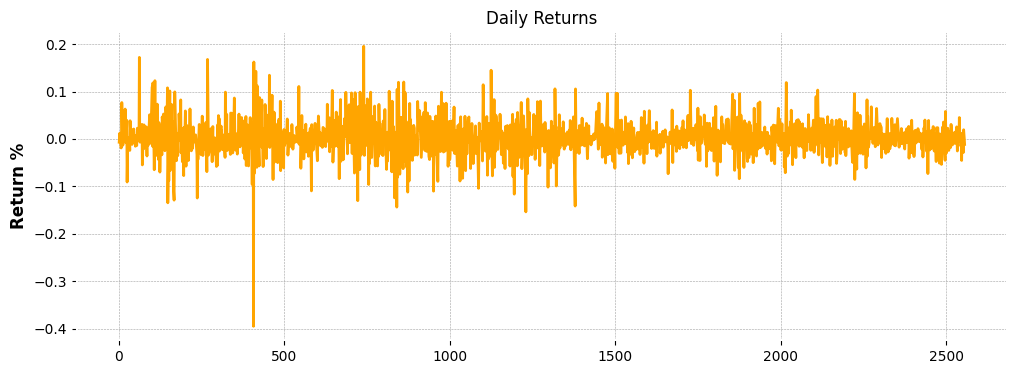

In [196]:
# volatility(daily returns)

data['daily_return'] = data['close'].pct_change()

plt.figure(figsize=(12,4))
plt.plot(data['daily_return'], color='orange')
plt.title("Daily Returns")
plt.ylabel("Return %")
plt.show()

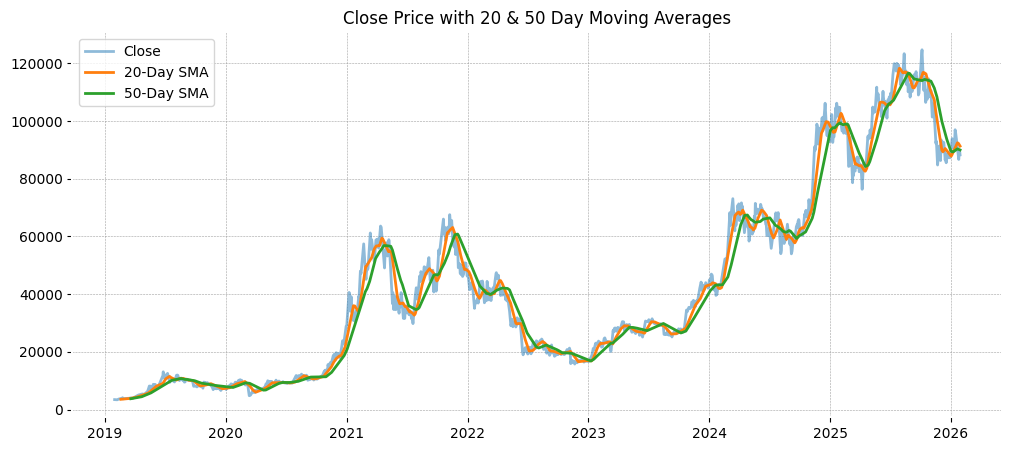

In [197]:
#  Moving average(SMA 20 AND SMA50)

df['SMA20'] = df['close'].rolling(window=20).mean()
df['SMA50'] = df['close'].rolling(window=50).mean()

plt.figure(figsize=(12,5))
plt.plot(df['close'], label='Close', alpha=0.5)
plt.plot(df['SMA20'], label='20-Day SMA', linewidth=2)
plt.plot(df['SMA50'], label='50-Day SMA', linewidth=2)
plt.title("Close Price with 20 & 50 Day Moving Averages")
plt.legend()
plt.show()

 BOX PLOT OF DAILY RETURNS PER MONTH

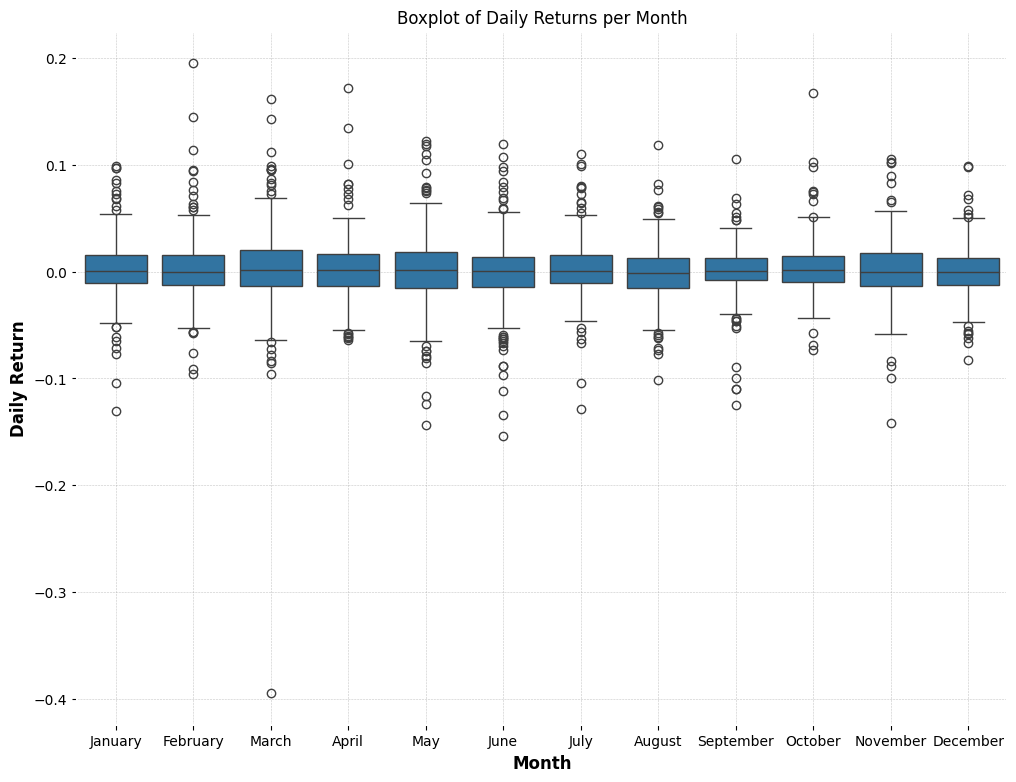

In [198]:
# Ensure timestamp is in datetime format
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Calculate Daily Returns
data['daily_return'] = data['close'].pct_change()

# Extract Month Name
data['Month'] = data['timestamp'].dt.month_name()

# Drop NaN values created from pct_change()
data = data.dropna(subset=['daily_return'])

# Define correct month order
month_order = ["January","February","March","April","May","June",
               "July","August","September","October","November","December"]

# Boxplot
plt.figure(figsize=(12,9))
sns.boxplot(x='Month', y='daily_return', data=data, order=month_order)

plt.title("Boxplot of Daily Returns per Month")
plt.xlabel("Month")
plt.ylabel("Daily Return")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


                            FORECASTING MODEL

In [199]:
def evaluate_model(actual, predicted, model_name):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    r2 = r2_score(actual, predicted)
    print(f"\n{model_name} Performance:")
    print(f"MAE  : {mae:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"MAPE : {mape:.2f}%")
    print(f"R2_score:{r2:.4f}")

In [200]:
# data.tail()

In [201]:
data = pd.read_csv(r"C:\ALL PROJECTS\Time-Series-Crypto-Analysis\binance_crypto_data_file.csv")  # everytime run the data while using models

prophet model


11:05:08 - cmdstanpy - INFO - Chain [1] start processing
11:05:09 - cmdstanpy - INFO - Chain [1] done processing


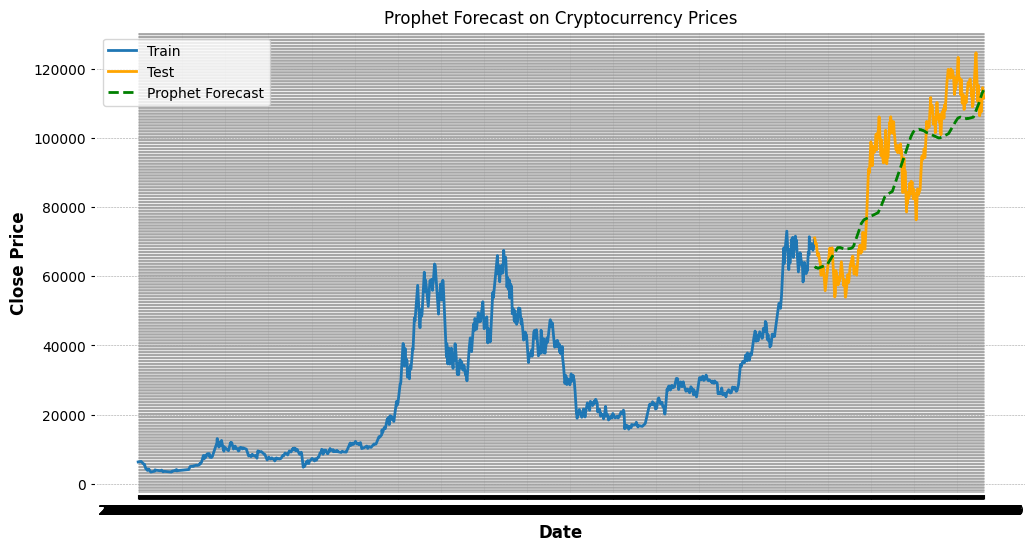


Prophet Performance:
MAE  : 9520.6139
RMSE : 11219.5088
MAPE : 10.71%
R2_score:0.7001


In [202]:

# Prepare data for Prophet
df = data[['timestamp', 'close']].rename(columns={'timestamp': 'ds', 'close': 'y'})

# Split into train & test
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# Build & train model
model = Prophet()
model.fit(train)

# Forecast for the same length as the test set
future = model.make_future_dataframe(periods=len(test), freq='D')
forecast = model.predict(future)

# Extract predictions
prophet_pred = forecast['yhat'][-len(test):].values

# Plot actual vs predicted
plt.figure(figsize=(12,6))
plt.plot(train['ds'], train['y'], label='Train', linewidth=2)
plt.plot(test['ds'], test['y'], label='Test', color='orange', linewidth=2)
plt.plot(test['ds'], prophet_pred, label='Prophet Forecast', color='green', linestyle='--', linewidth=2)
plt.legend()
plt.title("Prophet Forecast on Cryptocurrency Prices")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

#Evaluate prophet evaluation 
evaluate_model(test['y'], prophet_pred, "Prophet")

ARIMA MODEL

C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


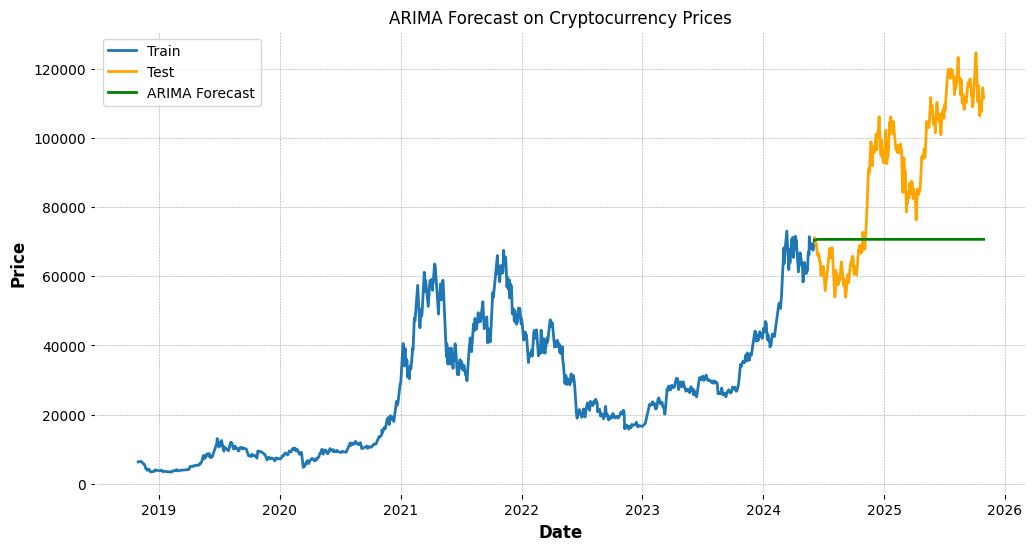


ARIMA Performance:
MAE  : 24260.3403
RMSE : 28347.6511
MAPE : 24.70%
R2_score:-0.9144


In [203]:

# ARIMA MODEL
# Convert timestamp column to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])
data = data.sort_values(by='timestamp')

# Use closing price for time series
data.set_index('timestamp', inplace=True)
data = data[['close']].rename(columns={'close': 'price'})

# Split train and test (80%-20%)
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Build ARIMA model
arima_model = ARIMA(train, order=(5,1,0))
arima_fit = arima_model.fit()

# Forecast for test period
arima_pred = arima_fit.forecast(steps=len(test))

# Plot results
plt.figure(figsize=(12,6))
plt.plot(train.index, train['price'], label='Train')
plt.plot(test.index, test['price'], label='Test', color='orange')
plt.plot(test.index, arima_pred, label='ARIMA Forecast', color='green')
plt.legend()
plt.title("ARIMA Forecast on Cryptocurrency Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

evaluate_model(test['price'], arima_pred, "ARIMA")

# LSTM  MODEL

    LSTM

In [206]:
#Step 1: Required Imports
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [207]:
print(df.columns)


Index(['ds', 'y'], dtype='object')


In [208]:
columns = ['timestamp','open','high','low','close','volume',
           'close_time','quote_asset_volume','number_of_trades',
           'taker_buy_base_asset_volume','taker_buy_quote_asset_volume','ignore']

df = pd.DataFrame(klines, columns=columns)



In [209]:
df[['open','high','low','close','volume']] = df[['open','high','low','close','volume']].astype(float)


In [210]:
print(df[['open','high','low','close','volume']].head())


      open     high      low    close        volume
0  3410.04  3478.00  3387.10  3458.18  23968.260243
1  3457.50  3489.20  3418.80  3434.10  29607.190253
2  3434.10  3488.00  3401.20  3462.07  25260.476159
3  3462.20  3526.40  3440.29  3504.77  17920.802000
4  3504.06  3511.09  3426.00  3458.11  19867.336390


In [211]:
#Step 2: Use the CORRECT DataFrame
prices = df['close'].values.reshape(-1, 1)


In [212]:
#step 3:  Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(prices)

In [213]:
# Step 4: Train–Test Split
training_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:training_size]
test_data = scaled_data[training_size:]


In [214]:
#Step 5: Create Dataset
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i-time_step:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_data, 60)
X_test, y_test = create_dataset(test_data, 60)


In [215]:
# Step 6: Reshape for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [216]:
# Step 7: Build LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(60, 1)))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')


C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0048
Epoch 2/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 4.9036e-04
Epoch 3/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 4.5434e-04
Epoch 4/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 3.9757e-04
Epoch 5/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 3.5600e-04
Epoch 6/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 3.6469e-04
Epoch 7/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 3.6028e-04
Epoch 8/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 4.6445e-04
Epoch 9/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 2.8022e-04
Epoch 10/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 2.9451e-04
Epoch 11/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 2.7481e-04
Epoch 12/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 2.4493e-04
Epoch 13/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 2.3864e-04
Epoch 14/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 2.2655e-04
Epoch 15/25
63/63 ━

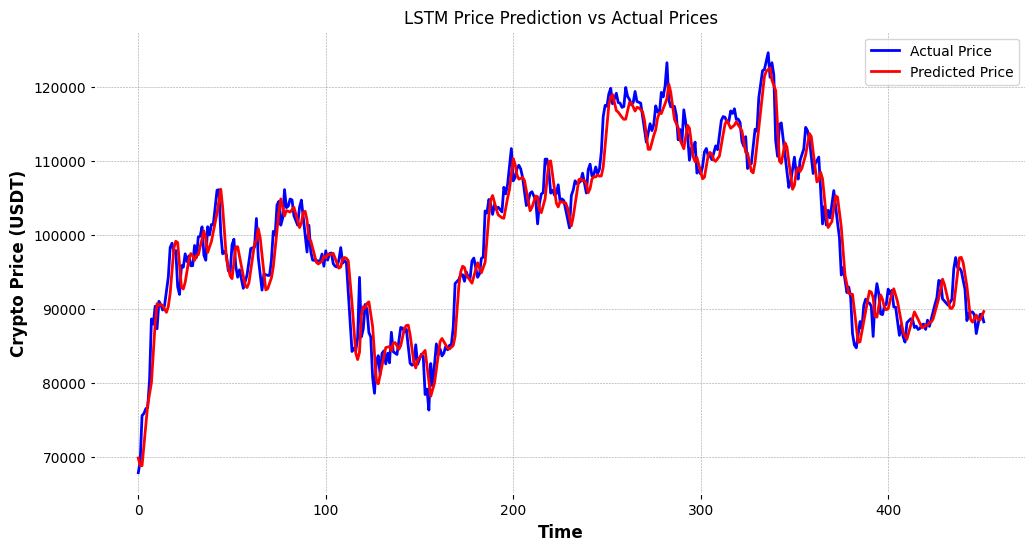


LSTM Performance:
MAE  : 1997.9159
RMSE : 2564.0268
MAPE : 2.03%
R2_score:0.9502


In [217]:
# Step 8: Train the model

history = model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=1)


# Step 9: Predict using the model

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Convert back to actual scale
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))


# Step 10: Plot predictions vs actual prices

plt.figure(figsize=(12,6))
plt.plot(actual_prices, label='Actual Price', color='blue')
plt.plot(predictions, label='Predicted Price', color='red')
plt.title("LSTM Price Prediction vs Actual Prices")
plt.xlabel("Time")
plt.ylabel("Crypto Price (USDT)")
plt.legend()
plt.show()

#step 11: Evaluation
evaluate_model(actual_prices, predictions, "LSTM")

C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: Value

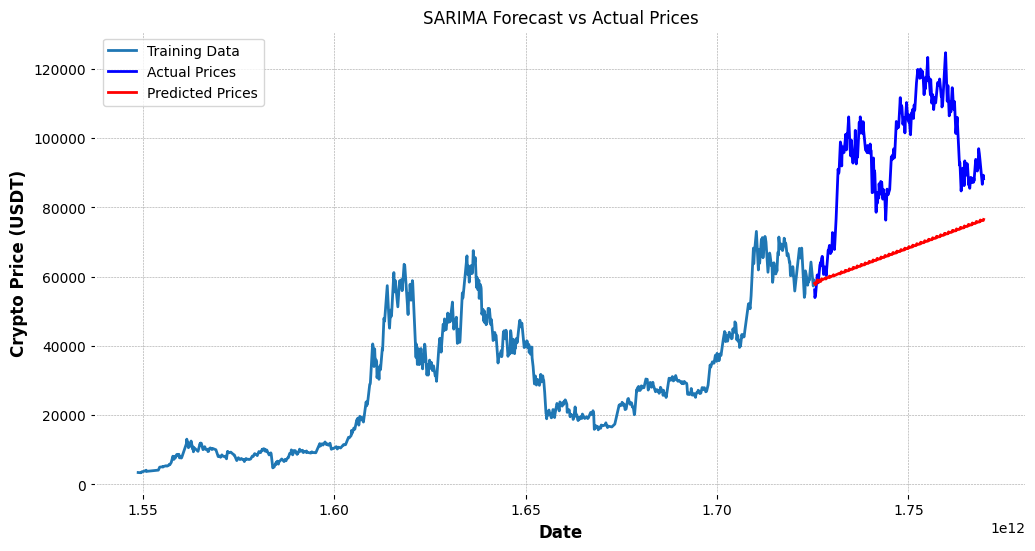


SARIMA Performance:
MAE  : 28442.1426
RMSE : 31586.2139
MAPE : nan%
R2_score:-2.9116


In [219]:
# SARIMA MODEL
# Convert timestamp to datetime and set as index
data['timestamp'] = pd.to_datetime(df['timestamp'])
data = df.sort_values('timestamp')
data.set_index('timestamp', inplace=True)

# Use only 'close' price for analysis
prices = data['close']
train_size = int(len(prices) * 0.8)
train, test = prices.iloc[:train_size], prices.iloc[train_size:]

# Step 3️⃣: Build and fit SARIMA model

# Parameters (p,d,q)(P,D,Q,s)
# p,d,q = ARIMA order; P,D,Q,s = seasonal order (s = season length)
model = SARIMAX(train, order=(2,1,2), seasonal_order=(1,1,1,12), enforce_stationarity=False, enforce_invertibility=False)
sarima_model = model.fit(disp=False)

# Step 4️⃣: Forecast future values
forecast = sarima_model.predict(start=len(train), end=len(prices)-1, dynamic=False)
# Step 6️⃣: Plot actual vs forecasted prices
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Prices', color='blue')
plt.plot(test.index, forecast, label='Predicted Prices', color='red')
plt.title("SARIMA Forecast vs Actual Prices")
plt.xlabel("Date")
plt.ylabel("Crypto Price (USDT)")
plt.legend()
plt.grid(True)
plt.show()

evaluate_model(test, forecast, "SARIMA")

Model comaprison

In [254]:
evaluate_model(test, arima_pred, "ARIMA")

evaluate_model(test, prophet_pred, "Prophet")

evaluate_model(test, forecast, "LSTM")

evaluate_model(test, forecast, "SARIMA")
#evaluate_model(test, sarima_pred, "SARIMA")



ARIMA stored successfully

Prophet stored successfully

LSTM stored successfully

SARIMA stored successfully


In [255]:
#Step 1: Store each model’s metrics separately

import pandas as pd
import numpy as np

results = {
    "ARIMA": {
        "MAE": 24260.3493,
        "RMSE": 28347.6511,
        "MAPE": 24.70,
        "R2": -0.9144
    },
    "SARIMA": {
        "MAE": 28442.1426,
        "RMSE": 31586.2139,
        "MAPE": np.nan,
        "R2": -2.9116
    },
    "Prophet": {
        "MAE": 9520.6139,
        "RMSE": 11219.5088,
        "MAPE": 10.71,
        "R2": 0.7001
    },
    "LSTM": {
        "MAE": 1997.9159,
        "RMSE": 2564.9268,
        "MAPE": 2.03,
        "R2": 0.9502
    }
}


In [256]:
#Step 2: Create comparison table

df = pd.DataFrame(results).T
df


,MAE,RMSE,MAPE,R2
ARIMA,24260.3493,28347.6511,24.70,-0.9144
SARIMA,28442.1426,31586.2139,NaN,-2.9116
Prophet,9520.6139,11219.5088,10.71,0.7001
LSTM,1997.9159,2564.9268,2.03,0.9502


In [257]:
#Step 3: Rank models by ACCURACY

df["Rank"] = df["R2"].rank(ascending=False)


In [258]:
# Step 4: Add ⭐ Star Rating Automatically

def star_rating(rank):
    if rank == 1:
        return "⭐⭐⭐⭐⭐"
    elif rank == 2:
        return "⭐⭐⭐⭐"
    elif rank == 3:
        return "⭐⭐"
    else:
        return "⭐"

df["Rating"] = df["Rank"].apply(star_rating)


In [259]:
# Step 5: Final sorted comparison table

final_comparison = df.sort_values("Rank")
final_comparison


,MAE,RMSE,MAPE,R2,Rank,Rating
LSTM,1997.9159,2564.9268,2.03,0.9502,1.0,⭐⭐⭐⭐⭐
Prophet,9520.6139,11219.5088,10.71,0.7001,2.0,⭐⭐⭐⭐
ARIMA,24260.3493,28347.6511,24.70,-0.9144,3.0,⭐⭐
SARIMA,28442.1426,31586.2139,NaN,-2.9116,4.0,⭐


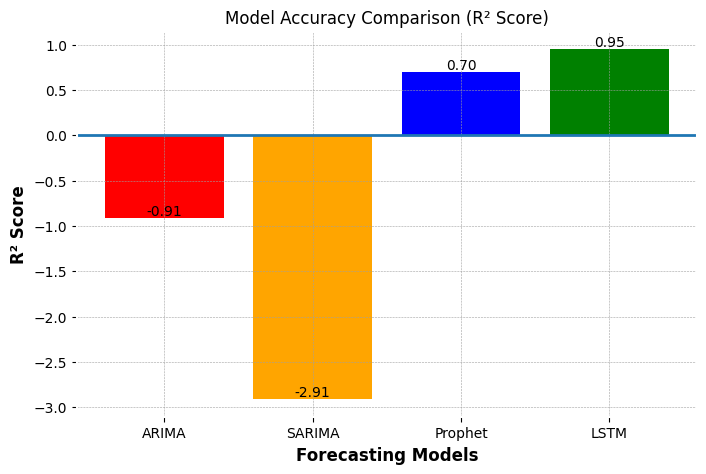

In [267]:
import matplotlib.pyplot as plt

models = ["ARIMA", "SARIMA", "Prophet", "LSTM"]
r2_scores = [-0.9144, -2.9116, 0.7001, 0.9502]

colors = ["red", "orange", "blue", "green"]

plt.figure(figsize=(8,5))
plt.bar(models, r2_scores, color=colors)
plt.axhline(0)  # reference line

plt.title("Model Accuracy Comparison (R² Score)")
plt.xlabel("Forecasting Models")
plt.ylabel("R² Score")

for i, v in enumerate(r2_scores):
    plt.text(i, v, f"{v:.2f}", ha='center', va='bottom')

plt.show()


In [ ]:
#Color Meaning (for explanation)

#🔴 ARIMA → poor accuracy

#🟠 SARIMA → worst accuracy

#🔵 Prophet → good accuracy

#🟢 LSTM → best accuracy

In [268]:
# Find best performing model based on highest R2 score

best_model = final_comparison.iloc[0]

print("Final Answer :\n")
print(f"{best_model.name} has the best performance rating {best_model['Rating']}")


Final Answer :

LSTM has the best performance rating ⭐⭐⭐⭐⭐
